In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#stopwords
from nltk.corpus import stopwords
from nltk.util import ngrams
stop=set(stopwords.words('english'))

#split word in a sentence
from nltk.tokenize import word_tokenize

#spelling correction
from spellchecker import SpellChecker

#showing a progress bar
from tqdm import tqdm

import string
import re
from collections import defaultdict
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Input
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
train_tweets = pd.read_csv('data/train.csv')
test_tweets = pd.read_csv('data/test.csv')

In [3]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_tweets['text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 7613, dtype: object

In [5]:
test_tweets.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### EDA(Exploratory Data Analysis)
#### number of characters; number of words
#### common stopwords
#### punctuations
#### Common words

#### Number of characters in training data

Text(0.5, 0.98, 'Characters in Tweets')

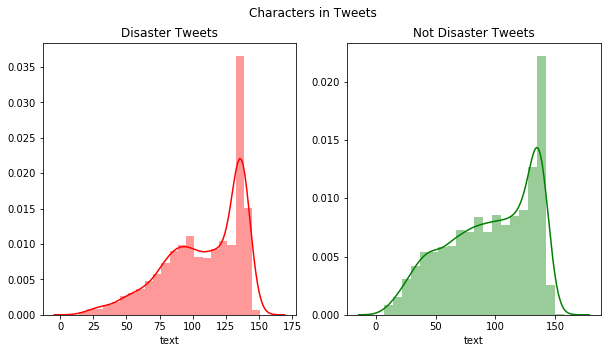

In [6]:
#number of characters for disaster tweets and not disaster tweets
disaster_tweets_len = train_tweets[train_tweets['target'] == 1]['text'].str.len()
not_disaster_tweets_len = train_tweets[train_tweets['target'] == 0]['text'].str.len()

#hist
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(disaster_tweets_len,color = 'red', ax=ax1)
ax1.set_title('Disaster Tweets')
sns.distplot(not_disaster_tweets_len, color = 'green', ax = ax2)
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Characters in Tweets')

#### Number of words in training data

Text(0.5, 0.98, 'Words in Tweets')

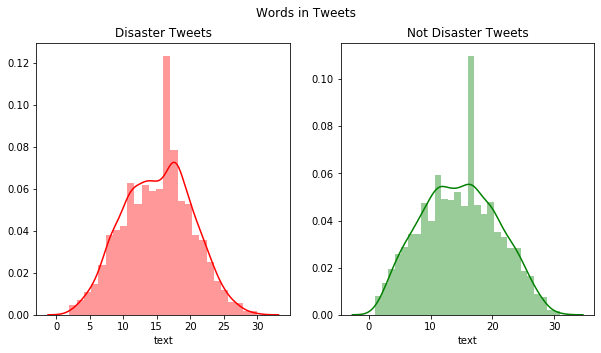

In [7]:
#number of characters for disaster tweets and not disaster tweets
disaster_tweets_words = train_tweets[train_tweets['target'] == 1]['text'].str.split().map(lambda x: len(x))
not_disaster_tweets_words = train_tweets[train_tweets['target'] == 0]['text'].str.split().map(lambda x: len(x))

#hist
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(disaster_tweets_words,color = 'red', ax=ax1)
ax1.set_title('Disaster Tweets')
sns.distplot(not_disaster_tweets_words, color = 'green', ax = ax2)
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Words in Tweets')


In [8]:
#corpus

def create_corpus(target):
    corpus = []
    
    for tweet in train_tweets[train_tweets['target'] == target]['text'].str.split():
        for word in tweet:
            corpus.append(word)
            
    return corpus

#### Common stopwords in tweets

In [9]:
#class 1
dic_stop_1 = defaultdict(int)

corpus_1 = create_corpus(1)
for word in corpus_1:
    if word in stop:
        dic_stop_1[word] += 1
        
top_stop_1 = sorted(dic_stop_1.items(), key = lambda x : x[1],reverse=True)[:10] 
print(top_stop_1)

[('the', 1051), ('in', 1037), ('of', 888), ('a', 730), ('to', 706), ('and', 462), ('on', 386), ('for', 368), ('is', 302), ('at', 273)]


<BarContainer object of 10 artists>

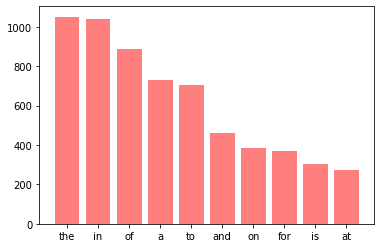

In [10]:
x,y=zip(*top_stop_1)
plt.bar(x,y, color = 'red', alpha = 0.5)

In [11]:
#class 0
dic_stop_0 = defaultdict(int)

corpus_0 = create_corpus(0)
for word in corpus_0:
    if word in stop:
        dic_stop_0[word] += 1
        
top_stop_0 = sorted(dic_stop_0.items(), key = lambda x : x[1],reverse=True)[:10] 
print(top_stop_0)

[('the', 1524), ('a', 1115), ('to', 1099), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452), ('my', 442)]


<BarContainer object of 10 artists>

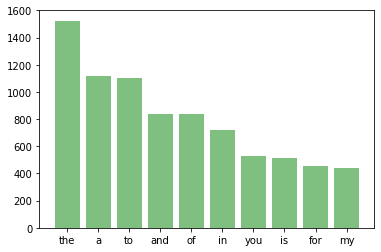

In [12]:
x,y=zip(*top_stop_0)
plt.bar(x,y, color = 'green', alpha = 0.5)

#### Analyzing punctuatiions

<BarContainer object of 18 artists>

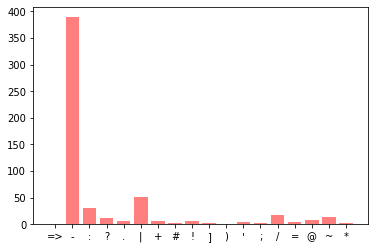

In [13]:
punctuation = string.punctuation

#class 1
dic_punc_1 = defaultdict(int)

for word in corpus_1:
    if word in punctuation:
        dic_punc_1[word] += 1

x,y=zip(*dic_punc_1.items())
plt.bar(x,y, color = 'red', alpha = 0.5)

<BarContainer object of 20 artists>

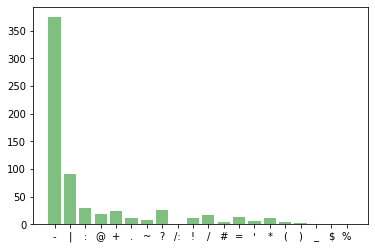

In [14]:
#class 0
dic_punc_0 = defaultdict(int)

for word in corpus_0:
    if word in punctuation:
        dic_punc_0[word] += 1

x,y=zip(*dic_punc_0.items())
plt.bar(x,y, color = 'green', alpha = 0.5)

#### Common words

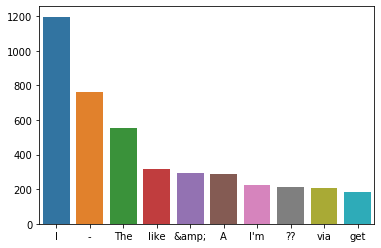

In [15]:
corpus = corpus_0 + corpus_1
counter = Counter(corpus)
common = counter.most_common()

x, y = [], []
for word, count in common[:50]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x,y)

### Data Cleaning
#### Remove urls; HTML tags;  punctuations

In [16]:
#train+test
data = pd.concat([train_tweets, test_tweets])
data.shape

(10876, 5)

#### Remove urls

In [17]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started, babaa"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched : babaa'

In [18]:
data['text']=data['text'].apply(lambda x : remove_URL(x))

#### Remove HTML tags

In [19]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

remove_html(example)

'\nReal or Fake\nKaggle \ngetting started\n'

In [20]:
data['text']=data['text'].apply(lambda x : remove_html(x))

#### Rmove Emojis

In [21]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

print(remove_emoji("Omg another Earthquake 😔😔"))
print(remove_emoji("Omg another Earthquake 哈"))
print(remove_emoji("Omg another Earthquake "))
print(remove_emoji("Omg another Earthquake ⌨️"))

Omg another Earthquake 
Omg another Earthquake 
Omg another Earthquake 
Omg another Earthquake ⌨


In [22]:
data['text']=data['text'].apply(lambda x : remove_emoji(x))

#### Remove punctuations

In [23]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king^_^"
print(remove_punct(example))

I am a king


In [24]:
data['text']=data['text'].apply(lambda x : remove_punct(x))

#### Spelling Correction

In [27]:
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me pleaee"
correct_spellings(text)

'correct me please'

In [28]:
data['text']=data['text'].apply(lambda x : correct_spellings(x))

### GloVe

In [29]:
def create_corpus(text):
    corpus=[]
    for tweet in tqdm(text):
        
        words = []
        for word in word_tokenize(tweet):
            word = word.lower()
            if word.isalpha() and word not in stop: words.append(word)
    
        corpus.append(words)
    return corpus

In [30]:
corpus = create_corpus(data['text'])

100%|██████████| 10876/10876 [00:01<00:00, 9629.13it/s]


In [31]:
corpus[:10]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hill', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['im', 'afraid', 'tornado', 'coming', 'area']]

In [32]:
embedding_dict={}
with open('glove/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype = np.float32)
        embedding_dict[word]=vectors
f.close()

In [33]:
embedding_dict['forest']

array([-0.51682 ,  0.49154 ,  0.66964 ,  0.40753 ,  0.034442,  0.24418 ,
       -0.13243 ,  0.73563 , -0.40207 , -0.5769  ,  0.096792, -0.20483 ,
        0.26341 , -0.42977 ,  0.060235,  0.31668 ,  1.4883  ,  0.47245 ,
       -0.26586 ,  0.47824 , -0.11281 ,  0.42528 ,  0.5677  ,  0.4602  ,
       -0.093104,  0.32335 , -0.23002 , -0.16198 , -1.2648  , -0.36222 ,
       -0.88619 , -0.035982,  0.36223 , -0.25235 , -0.060168, -0.25055 ,
       -0.34484 ,  0.21948 ,  0.48187 ,  0.3856  , -0.76828 , -0.25247 ,
       -0.27788 ,  0.096147,  1.2709  ,  0.43127 , -0.32322 ,  0.65685 ,
       -0.034062, -0.49976 , -0.034357, -0.74292 , -0.34103 ,  0.74702 ,
        0.89229 , -1.6595  ,  0.35286 , -0.50011 ,  1.308   , -0.050792,
        0.43306 ,  0.82356 , -0.12208 , -0.61102 ,  0.86892 ,  0.176   ,
        0.73954 ,  0.10994 ,  1.1845  , -0.39517 , -0.30585 , -0.27726 ,
        0.89918 , -0.49852 ,  0.028042, -0.83807 ,  0.32606 ,  0.542   ,
       -0.47404 ,  1.1243  ,  0.44922 ,  0.17852 , 

In [34]:
#example
tok =Tokenizer()
tok.fit_on_texts(corpus[:2])
word_index = tok.word_index
print(word_index)
sequences = tok.texts_to_sequences(corpus[:2])
print(sequences)

#转化成词袋序列
maxlen = 10
from keras.preprocessing import sequence
x = sequence.pad_sequences(sequences, maxlen,dtype='int16')
print(x)

{'deeds': 1, 'reason': 2, 'earthquake': 3, 'may': 4, 'allah': 5, 'forgive': 6, 'us': 7, 'forest': 8, 'fire': 9, 'near': 10, 'la': 11, 'ronge': 12, 'sask': 13, 'canada': 14}
[[1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14]]
[[ 0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  8  9 10 11 12 13 14]]


In [35]:
pad_sequences(sequences,maxlen=5,padding='post')

array([[ 3,  4,  5,  6,  7],
       [10, 11, 12, 13, 14]], dtype=int32)

In [36]:
#create index for every word
MAX_LEN=50
tokenizer =Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences,maxlen = MAX_LEN,truncating = 'post',padding = 'post') #在序列后缩短，填充

num_words = len(word_index)
print('Number of unique words:', num_words)

Number of unique words: 19723


In [37]:
#embedding_matrix = {index: vectors}
embedding_matrix = np.zeros((num_words+1, 100))

for word, i in tqdm(word_index.items()):     
    embedding_vec = embedding_dict.get(word)
    
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

100%|██████████| 19723/19723 [00:00<00:00, 424170.41it/s]


### Model

### Unidirectional LSTM

In [146]:
model = Sequential()

embedding=Embedding(num_words+1, 100, embeddings_initializer = Constant(embedding_matrix), input_length = MAX_LEN,trainable = False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation = 'sigmoid'))


optimzer = Adam(learning_rate = 1e-5)

model.compile(loss = 'binary_crossentropy',optimizer = optimzer,metrics = ['accuracy'])

In [147]:
model.summary()

#output shape: batch * max_len of a sentence * vectors for one word

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1972400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,014,705
Trainable params: 42,305
Non-trainable params: 1,972,400
_________________________________________________________________


In [153]:
train_data_num = train_tweets.shape[0]

#seperate train and test
train = tweet_pad[: train_data_num]
test = tweet_pad[train_data_num: ]

#seperate train data into train and validation
X_train, X_test, y_train, y_test = train_test_split(train, train_tweets['target'].values, test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [154]:
history = model.fit(X_train, y_train ,batch_size=4, epochs=15, validation_data = (X_test, y_test), verbose=2)

Epoch 1/15
1618/1618 - 55s - loss: 0.6900 - accuracy: 0.5688 - val_loss: 0.6723 - val_accuracy: 0.5736
Epoch 2/15
1618/1618 - 52s - loss: 0.5708 - accuracy: 0.7323 - val_loss: 0.5223 - val_accuracy: 0.7697
Epoch 3/15
1618/1618 - 50s - loss: 0.5300 - accuracy: 0.7574 - val_loss: 0.5063 - val_accuracy: 0.7758
Epoch 4/15
1618/1618 - 52s - loss: 0.5176 - accuracy: 0.7659 - val_loss: 0.4963 - val_accuracy: 0.7811
Epoch 5/15
1618/1618 - 53s - loss: 0.5089 - accuracy: 0.7727 - val_loss: 0.4890 - val_accuracy: 0.7837
Epoch 6/15
1618/1618 - 52s - loss: 0.5026 - accuracy: 0.7759 - val_loss: 0.4857 - val_accuracy: 0.7863
Epoch 7/15
1618/1618 - 51s - loss: 0.5003 - accuracy: 0.7769 - val_loss: 0.4803 - val_accuracy: 0.7881
Epoch 8/15
1618/1618 - 50s - loss: 0.4901 - accuracy: 0.7830 - val_loss: 0.4752 - val_accuracy: 0.7881
Epoch 9/15
1618/1618 - 51s - loss: 0.4902 - accuracy: 0.7773 - val_loss: 0.4701 - val_accuracy: 0.7890
Epoch 10/15
1618/1618 - 50s - loss: 0.4840 - accuracy: 0.7843 - val_loss:

In [160]:
history.history

{'loss': [0.6899847984313965,
  0.5708134770393372,
  0.5300047993659973,
  0.5176488161087036,
  0.5088512301445007,
  0.5026304125785828,
  0.5003452897071838,
  0.49012240767478943,
  0.49016574025154114,
  0.48404401540756226,
  0.4818706512451172,
  0.4806632101535797,
  0.4789738059043884,
  0.48043280839920044,
  0.469277024269104],
 'accuracy': [0.5688456296920776,
  0.7323443293571472,
  0.7573790550231934,
  0.7658785581588745,
  0.7726780772209167,
  0.7759233713150024,
  0.7768505811691284,
  0.7830320000648499,
  0.7773141860961914,
  0.7842682600021362,
  0.7855045795440674,
  0.7833410501480103,
  0.7870498895645142,
  0.7844228148460388,
  0.7921496033668518],
 'val_loss': [0.6723041534423828,
  0.5222788453102112,
  0.5062822103500366,
  0.4962734282016754,
  0.48901090025901794,
  0.48565924167633057,
  0.480316698551178,
  0.47516265511512756,
  0.4700588285923004,
  0.4721943736076355,
  0.47096678614616394,
  0.4653335213661194,
  0.46109750866889954,
  0.459623545

Text(0.5, 0.98, 'Unidirectional LSTM')

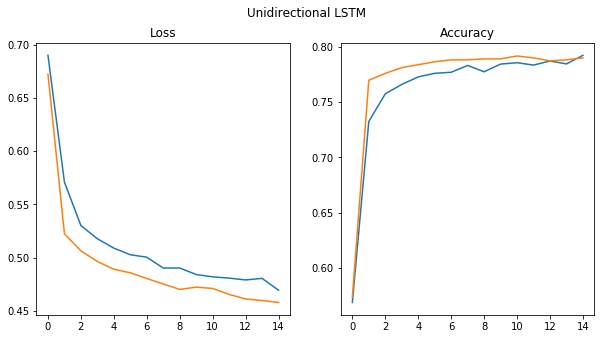

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Loss')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Accuracy')
fig.suptitle('Unidirectional LSTM')

### Bidirectional LSTM

In [173]:
bi_model = Sequential()

embedding=Embedding(num_words+1, 100, embeddings_initializer = Constant(embedding_matrix), input_length = MAX_LEN,trainable = False)

bi_model.add(embedding)
bi_model.add(SpatialDropout1D(0.2))
bi_model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout=0.2)))
bi_model.add(Dense(1, activation = 'sigmoid'))


optimzer = Adam(learning_rate = 1e-5)

bi_model.compile(loss = 'binary_crossentropy',optimizer = optimzer,metrics = ['accuracy'])

bi_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1972400   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 2,057,009
Trainable params: 84,609
Non-trainable params: 1,972,400
_________________________________________________________________


In [174]:
bi_history = bi_model.fit(X_train, y_train ,batch_size=4, epochs=15, validation_data = (X_test, y_test), verbose=2)

Epoch 1/15
1618/1618 - 77s - loss: 0.6733 - accuracy: 0.6101 - val_loss: 0.6484 - val_accuracy: 0.6681
Epoch 2/15
1618/1618 - 74s - loss: 0.5723 - accuracy: 0.7371 - val_loss: 0.5101 - val_accuracy: 0.7741
Epoch 3/15
1618/1618 - 74s - loss: 0.5196 - accuracy: 0.7619 - val_loss: 0.4926 - val_accuracy: 0.7706
Epoch 4/15
1618/1618 - 76s - loss: 0.5072 - accuracy: 0.7648 - val_loss: 0.4817 - val_accuracy: 0.7820
Epoch 5/15
1618/1618 - 74s - loss: 0.4915 - accuracy: 0.7781 - val_loss: 0.4724 - val_accuracy: 0.7855
Epoch 6/15
1618/1618 - 74s - loss: 0.4849 - accuracy: 0.7798 - val_loss: 0.4673 - val_accuracy: 0.7846
Epoch 7/15
1618/1618 - 76s - loss: 0.4780 - accuracy: 0.7843 - val_loss: 0.4600 - val_accuracy: 0.7933
Epoch 8/15
1618/1618 - 74s - loss: 0.4768 - accuracy: 0.7821 - val_loss: 0.4574 - val_accuracy: 0.7925
Epoch 9/15
1618/1618 - 75s - loss: 0.4745 - accuracy: 0.7815 - val_loss: 0.4540 - val_accuracy: 0.7916
Epoch 10/15
1618/1618 - 75s - loss: 0.4678 - accuracy: 0.7846 - val_loss:

Text(0.5, 0.98, 'Bidirectional LSTM')

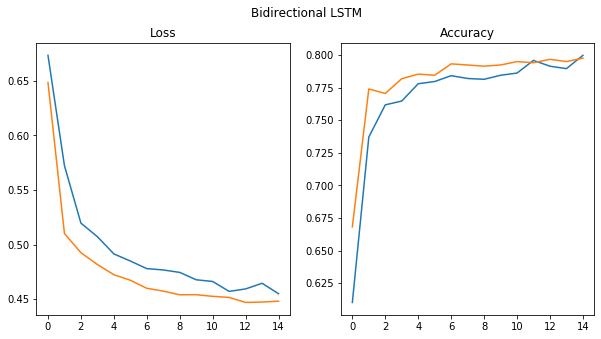

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(bi_history.history['loss'])
ax1.plot(bi_history.history['val_loss'])
ax1.set_title('Loss')
ax2.plot(bi_history.history['accuracy'])
ax2.plot(bi_history.history['val_accuracy'])
ax2.set_title('Accuracy')
fig.suptitle('Bidirectional LSTM')

### BERT

In [38]:
%%time


bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 4.7 s, sys: 677 ms, total: 5.38 s
Wall time: 5.6 s


In [195]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [40]:
import tokenization

In [41]:
def bert_encode(texts, tokenizer, max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [42]:
def build_model(bert_layer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [43]:
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [50]:
train_data_num = train_tweets.shape[0]

#seperate train and test
train_bert = data[: train_data_num]
test_bert = data[train_data_num: ]

#seperate train data into train and validation
# X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(train_bert, train_tweets['target'].values, test_size = 0.15)
# print('Shape of train', X_train_bert.shape)
# print("Shape of Validation ", X_test_bert.shape)

In [60]:
train_bert.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


In [62]:
train_bert.shape

(7613, 5)

In [52]:
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train_bert.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_bert.text.values, tokenizer, max_len=160)
train_labels = train_bert.target.values

In [57]:
Dropout_num = 0
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

In [58]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [63]:
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

Epoch 1/3
381/381 [==============================] - 3113s 8s/step - loss: 0.4374 - accuracy: 0.8090 - val_loss: 0.3954 - val_accuracy: 0.8293
Epoch 2/3
381/381 [==============================] - 3325s 9s/step - loss: 0.3000 - accuracy: 0.8798 - val_loss: 0.4342 - val_accuracy: 0.8148
Epoch 3/3
381/381 [==============================] - 2980s 8s/step - loss: 0.1757 - accuracy: 0.9360 - val_loss: 0.4472 - val_accuracy: 0.8162


Text(0.5, 0.98, 'BERT')

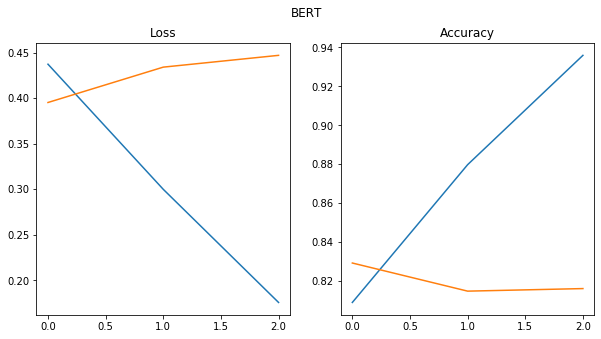

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(train_history.history['loss'])
ax1.plot(train_history.history['val_loss'])
ax1.set_title('Loss')
ax2.plot(train_history.history['accuracy'])
ax2.plot(train_history.history['val_accuracy'])
ax2.set_title('Accuracy')
fig.suptitle('BERT')